In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
class CustomMeanIoU:
    def __init__(self, threshold=.5, name=None):
        self.threshold = threshold
        if name is None:
            name = "MeanIoU"
        self.__name__ = name

    def __call__(self, y_true, y_pred):
        a = y_true == 1
        b = y_pred > self.threshold
        inter = tf.cast(tf.math.logical_and(a, b), "float32")
        union = tf.cast(tf.math.logical_or(a, b), "float32")
        return tf.reduce_sum(inter, axis=[1,2,3]) / tf.reduce_sum(union, axis=[1,2,3])

class ThresholdMeanIoU(MeanIoU):
    def __init__(self, num_classes, threshold=.5, name=None, dtype=None):
        super().__init__(num_classes, name=name, dtype=dtype)
        self.threshold = threshold
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(y_true, y_pred > self.threshold, sample_weight=sample_weight)

In [7]:
input_shape = (128, 128, 3)

conv_args = dict(kernel_size=(3,3), padding="same", activation="relu")

in_unet = Input(input_shape)
x = Conv2D(32, **conv_args)(in_unet)
x1 = Conv2D(32, **conv_args)(x)
x = MaxPool2D()(x1)

x = Conv2D(64, **conv_args)(x)
x2 = Conv2D(64, **conv_args)(x)
x = MaxPool2D()(x2)

x = Conv2D(128, **conv_args)(x)
x3 = Conv2D(128, **conv_args)(x)
x = MaxPool2D()(x3)

x = Conv2D(256, **conv_args)(x)
x4 = Conv2D(256, **conv_args)(x)
x = MaxPool2D()(x4)

x = Conv2D(512, **conv_args)(x)
x = Conv2D(512, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x4])
x = Conv2D(256, **conv_args)(x)
x = Conv2D(256, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x3])
x = Conv2D(128, **conv_args)(x)
x = Conv2D(128, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x2])
x = Conv2D(64, **conv_args)(x)
x = Conv2D(64, **conv_args)(x)

x = UpSampling2D()(x)
x = Concatenate(axis=-1)([x, x1])
x = Conv2D(32, **conv_args)(x)
x = Conv2D(32, **conv_args)(x)

out_unet = Conv2D(1, kernel_size=(3,3), padding="same", activation="sigmoid")(x)

unet = Model(in_unet, out_unet)

In [8]:
unet.compile(loss="binary_crossentropy", optimizer="adam",
             metrics=[MeanIoU(num_classes=2, name="keras_mean_iou"), CustomMeanIoU(threshold=.5)])

In [9]:
import data_generation

train_gen = data_generation.SegmentationDataGenerator("./test_dataset/train")
test_gen = data_generation.SegmentationDataGenerator("./test_dataset/test")

Found 14896 files.
Found 4965 files.


In [10]:
history = unet.fit(train_gen, validation_data=test_gen, epochs=15)

Epoch 1/15
465/465 [==============================] - 93s 195ms/step - loss: 0.4121 - mean_io_u: 0.4676 - custom_mean_io_u: 0.0136 - val_loss: 0.1465 - val_mean_io_u: 0.4676 - val_custom_mean_io_u: 0.1793
Epoch 2/15
465/465 [==============================] - 87s 187ms/step - loss: 0.1459 - mean_io_u: 0.4676 - custom_mean_io_u: 0.3057 - val_loss: 0.0993 - val_mean_io_u: 0.4676 - val_custom_mean_io_u: 0.5272
Epoch 3/15
465/465 [==============================] - 87s 187ms/step - loss: 0.1017 - mean_io_u: 0.4677 - custom_mean_io_u: 0.5228 - val_loss: 0.0642 - val_mean_io_u: 0.4676 - val_custom_mean_io_u: 0.6512
Epoch 4/15
465/465 [==============================] - 87s 188ms/step - loss: 0.0822 - mean_io_u: 0.4680 - custom_mean_io_u: 0.6063 - val_loss: 0.0563 - val_mean_io_u: 0.4676 - val_custom_mean_io_u: 0.6856
Epoch 5/15
465/465 [==============================] - 87s 188ms/step - loss: 0.0682 - mean_io_u: 0.4706 - custom_mean_io_u: 0.6570 - val_loss: 0.0510 - val_mean_io_u: 0.4678 - val_

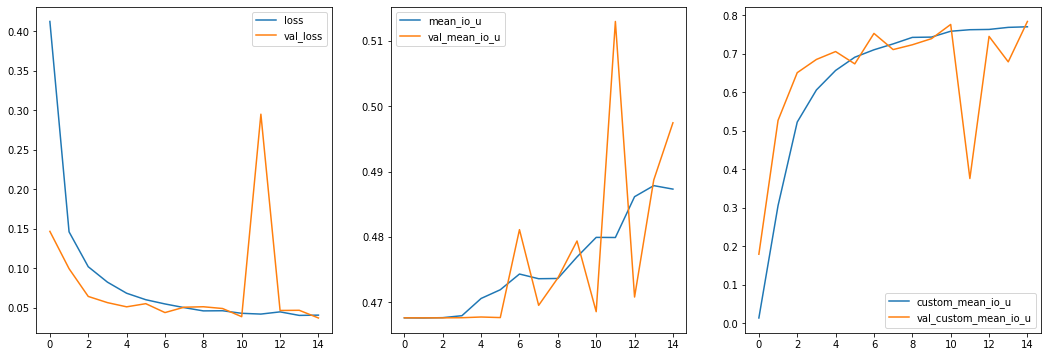

In [11]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
H = history.history
ax[0].plot(H["loss"], label="loss")
ax[0].plot(H["val_loss"], label="val_loss")
ax[0].legend()
ax[1].plot(H["mean_io_u"], label="mean_io_u")
ax[1].plot(H["val_mean_io_u"], label="val_mean_io_u")
ax[1].legend()
ax[2].plot(H["custom_mean_io_u"], label="custom_mean_io_u")
ax[2].plot(H["val_custom_mean_io_u"], label="val_custom_mean_io_u")
ax[2].legend()
plt.show()

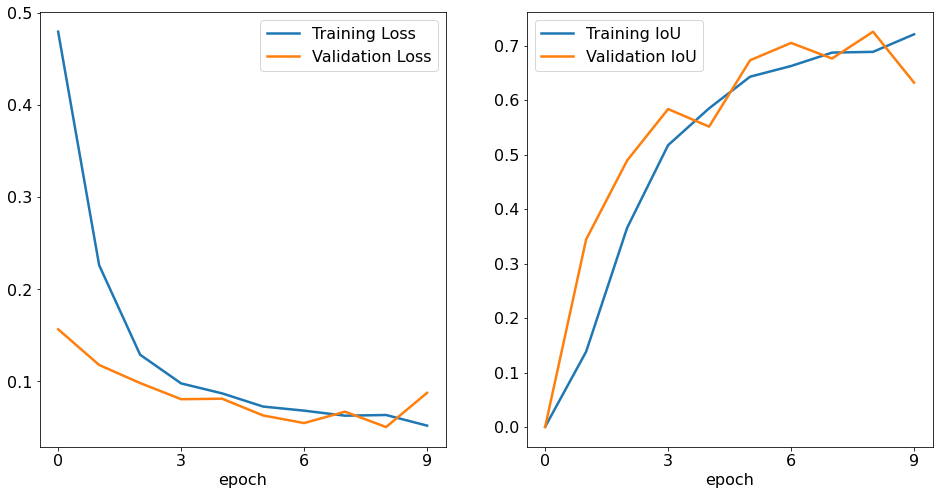

In [ ]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,2, figsize=(16,8))
H = history.history
lw = 2.5
ax[0].plot(H["loss"], lw=lw, label="Training Loss")
ax[0].plot(H["val_loss"], lw=lw, label="Validation Loss")
ax[0].set_xlabel("epoch")
ax[0].set_xticks([0,3,6,9])
ax[0].legend()
ax[1].plot(H["custom_mean_io_u"], lw=lw, label="Training IoU")
ax[1].plot(H["val_custom_mean_io_u"], lw=lw, label="Validation IoU")
ax[1].set_xlabel("epoch")
ax[1].set_xticks([0,3,6,9])
ax[1].legend()
plt.savefig("../plots/unet_v4_history.png", dpi=300)

In [12]:
X, y = test_gen.__getitem__(3)

In [13]:
y_pred = unet.predict(X)

In [14]:
custom_iou = CustomMeanIoU()(y, y_pred)
tf.reduce_mean(custom_iou)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7558466>

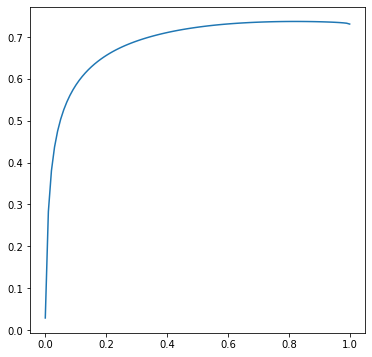

In [ ]:
iou = tf.keras.metrics.MeanIoU(num_classes=2)
# iou(y, y_pred>.5)
tresh = np.linspace(0, 1, 100)
iou_score = np.zeros_like(tresh)
for i, t in enumerate(tresh):
    iou_score[i] = iou(y, y_pred>t)

fig, ax = plt.subplots(figsize=(6,6))
plt.plot(tresh, iou_score)
plt.show()

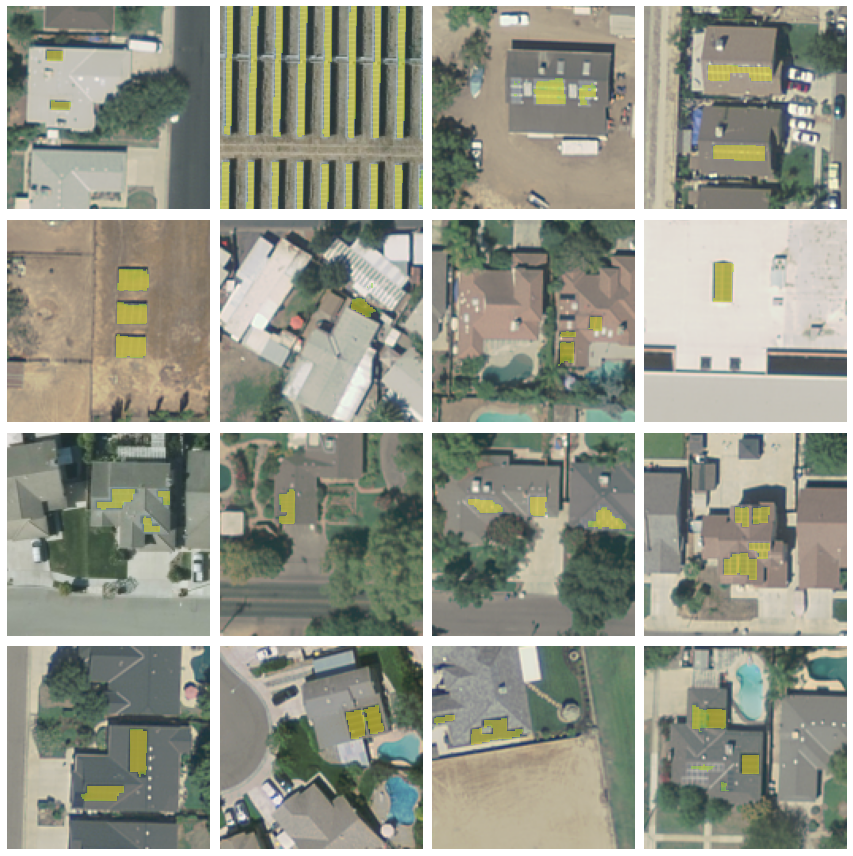

In [23]:
X, y = test_gen.__getitem__(6)
y_pred = unet.predict(X)

w, h = 4, 4
fig, ax = plt.subplots(h, w, figsize=(12,12))

for i in range(h):
    for j in range(w):
        ax[i,j].imshow(X[w*i+j])
        # ax[i,j].imshow(y[w*i+j,:,:,0], cmap="gray")
        ax[i,j].imshow(np.ma.masked_less(y_pred[w*i+j,:,:,0], .8), vmin=0, vmax=1, alpha=.5)
        # ax[i,j].imshow(y_pred[w*i+j,:,:,0], vmin=0, vmax=1, alpha=.5)
        ax[i,j].axis('off')

plt.tight_layout()
plt.show()

In [18]:
unet = keras.models.load_model("trained_models/Unet/unet_v4.tf")

OSError: SavedModel file does not exist at: trained_models/Unet/unet_v4.tf\{saved_model.pbtxt|saved_model.pb}

In [19]:
unet.save(r"trained_models\Unet\unet_v4.tf")

INFO:tensorflow:Assets written to: trained_models\Unet\unet_v4.tf\assets


AttributeError: 'CustomMeanIoU' object has no attribute '__name__'

In [46]:
from random import randint
import numpy as np

def rand1():
    return randint(0,1)*2-1

def rand3():
        return np.random.randint(2)*2-1

def rand3():
        return np.random.randint(2, size=100000)*2-1

In [56]:
x = np.array([[1,2],
              [3,4],
              [5,6]])

x[:,::-1]

array([[2, 1],
       [4, 3],
       [6, 5]])